# Installs

In [1]:
! pip install -q ucimlrepo


[notice] A new release of pip is available: 23.2.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [ ]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


# Framework
import torch
import torchvision

# Data and its management related libraries
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms

# For creating neural networks
import torch.nn as nn
import torch.nn.functional as F

# For optimizing neural networks
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# For metrics and analysis
from sklearn.metrics import r2_score
from torchsummary import summary

# For dataset loading
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from ucimlrepo import fetch_ucirepo

from tqdm.notebook import tqdm, trange

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Device in Use: cuda


# Set seed

In [4]:
torch.manual_seed(42)
np.random.seed(42)

# Load dataset

In [5]:
df = fetch_ucirepo(id=275).data.original
print(f"Dataset shape: {df.shape}")

Dataset shape: (17379, 17)


# EDA and pre-processing

Dropping `instant` and `dteday` as they are essentially indices for the data and are not useful in calculations.

In [6]:
df.drop(columns=['instant', 'dteday'], inplace=True)

Check for null and duplicate values and drop the rows

In [7]:
print(f"Duplicate rows in the dataset: {df.duplicated().sum()}")
print(f"Null rows in the dataset:\n{df.isnull().sum()}")
df = df.drop_duplicates()
df = df.dropna()

Duplicate rows in the dataset: 2
Null rows in the dataset:
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


One hot encode all the categorical features

In [8]:
df = pd.get_dummies(df, columns=['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit'], dtype=float)
df.shape

(17377, 62)

# Dataset splitting

In [9]:
X = df.drop(columns=['cnt'])
y = df['cnt']

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_test), len(X_val), len(X)

(12163, 2607, 2607, 17377)

## Scale data

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Convert to pytorch tensors

In [33]:
# Convert to torch tensors because PyTorch's deep learning models and operations require tensors as inputs.
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_torch = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_torch = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

## Create dataloaders

In [34]:
# Create TensorDatasets for training, validation, and testing data
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Define batch size
batch_size = 1024

# Create DataLoaders for training, validation, and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network

In [35]:
# Define the fully connected neural network
class DigitsNet(nn.Module):
    def __init__(self):
        super(DigitsNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)  # Hidden layer 1
        self.fc2 = nn.Linear(128, 64)          # Hidden layer 2
        self.fc3 = nn.Linear(64, 32)           # Hidden layer 3
        self.fc4 = nn.Linear(32, 16)           # Hidden layer 4
        self.fc5 = nn.Linear(16, 1)            # Output layer (1 output, regression problem)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x) # ReLU activation for output layer as well as the output layer is the count of bicycles rented and that cannot be negative.
        return x

# Training

In [44]:
lr_history = []

def train_and_evaluate_regression(model, learning_rate, trainloader, valloader, testloader, optimizer, epochs=30, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in trange(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in tqdm(trainloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are the correct shape
            optimizer.zero_grad()  # Zeroing the Gradients
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, labels) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(valloader, leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)

        val_loss /= total
        val_loss_history.append(val_loss)

        if (epoch + 1) % 10 == 0:
            tqdm.write(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)  # Update the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        if len(lr_history) > 1 and current_lr != lr_history[-2]:
            tqdm.write(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                tqdm.write("Early stopping triggered.")
                break
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            r2 = r2_score(all_labels, all_preds)

    return train_loss_history, val_loss_history, r2

## With custom Adam

In [ ]:
class MomentumOptimizer(Optimizer):
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        # Stores default hyperparameters (lr and momentum).
        defaults = {'lr': lr, 'momentum': momentum}
        super().__init__(parameters, defaults)
        # self.param_groups: Stores groups of parameters.
        # {id(p): torch.zeros_like(p)}: Creates a dictionary where: Keys: id(p) (unique identifier for each parameter).
        # Values: torch.zeros_like(p) (same shape as p, initialized to zero).
        # This initializes momentum velocity to zero for each parameter.
        self.velocities = {id(p): torch.zeros_like(p) for group in self.param_groups for p in group['params']}

    def step(self, closure=None):
        with torch.no_grad():
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    # v = self.velocities[id(p)]: Retrieves the momentum term for parameter p.
                    v = self.velocities[id(p)]
                    # v.mul_(group['momentum']): Multiplies v by momentum coefficient 𝛽 (in-place update).
                    # .add_(p.grad, alpha=group['lr']): Adds gradient scaled by learning rate.
                    v.mul_(group['momentum']).add_(p.grad, alpha=group['lr'])
                    # p.sub_(v): Updates the parameter using momentum gradient descent:
                    p.sub_(v)

    def zero_grad(self):
      # This function clears gradients before the next update to avoid incorrect updates.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.zero_()

class RMSpropOptimizer(Optimizer):
    def __init__(self, parameters, lr=0.01, alpha=0.9, epsilon=1e-10):
      #Intialize the default parameters
        defaults = {
            'lr': lr,
            'alpha': alpha,
            'epsilon': epsilon
        }
        super().__init__(parameters, defaults)

    def step(self, closure=None):
        with torch.no_grad():
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        # Retrieve optimizer-specific parameters
                        alpha = group['alpha']
                        epsilon = group['epsilon']
                        lr = group['lr']

                        # Initialize state for this parameter if not already done
                        state = self.state[p]
                        if 'squared_gradient' not in state:
                            state['squared_gradient'] = torch.zeros_like(p)

                        # Update squared gradient
                        squared_gradient = state['squared_gradient']
                        squared_gradient.mul_(alpha).add_(p.grad ** 2 * (1 - alpha))

                        # Compute adjusted learning rate and update parameter
                        adjusted_lr = lr / (torch.sqrt(squared_gradient + epsilon))
                        p.sub_(p.grad * adjusted_lr)
    # After each step, we set all the gradients to zero, preparing for the next backpropagation pass.
    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.zero_()

class AdamOptimizer(Optimizer):
    def __init__(self, parameters, lr, rho_1 = 0.9, rho_2 = 0.9, epsilon = 1e-10):
        defaults = {
            'lr': lr,
            'rho_1': rho_1,
            'rho_2': rho_2,
            'epsilon': epsilon
        }
        super().__init__(parameters, defaults)

    def step(self):
        with torch.no_grad():
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        rho_1 = group['rho_1']
                        rho_2 = group['rho_2']
                        epsilon = group['epsilon']
                        lr = group['lr']

                        state = self.state[p]
                        if 'squared_gradient' not in state:
                            state['squared_gradient'] = torch.zeros_like(p)

                        

## With PyTorch Adam

In [ ]:
# Initialize the model
net = DigitsNet()
net = net.to(device)

learning_rate = 1e-1
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Placeholder for results
results1 = {}

# Train the model with different learning rates and store the results

train_loss, val_loss, r2 = train_and_evaluate_regression(net, learning_rate, trainloader, valloader, testloader, optimizer, epochs=70)
result = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'r2_score': r2
}

print(f'Final R2 Score on Test Set: {result["r2_score"]:.4f}')

# Plot

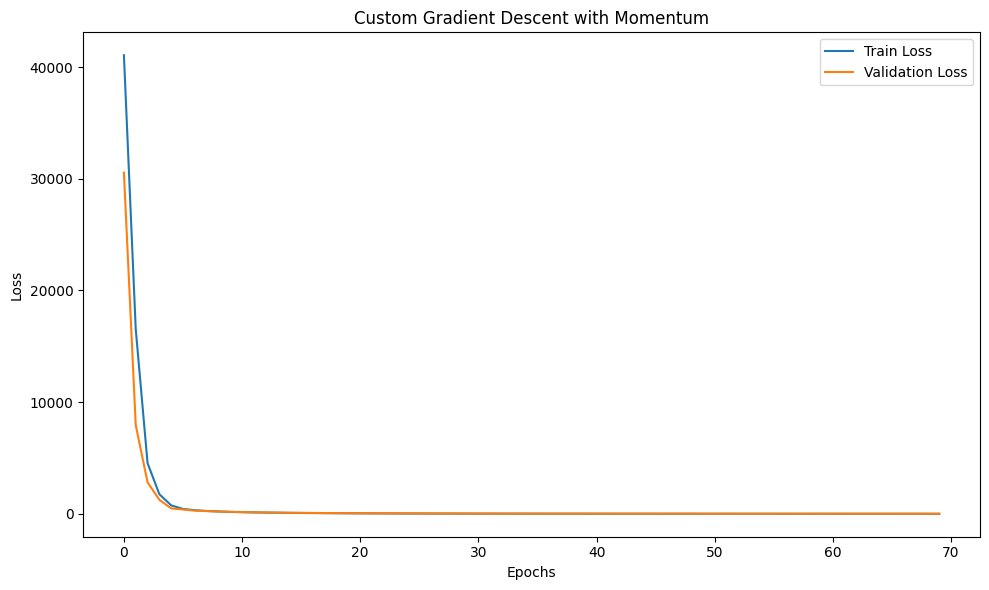

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('GD with PyTorch Adam Optimizer')

plt.plot(result['train_loss'], label=f'Train Loss')
plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
